# NLP 6iCa -  Assignment 4
## Author: Benjamin Brodwolf
### Date: 08.06.2020

__________________________________________________________________________________________________________________________

## HINWEIS: Word2Vec-File wird benötigt
Benutze das vortraintierten Embedding von Glove: [Glove-6B-300D](https://nlp.stanford.edu/projects/glove/) 

Kann hier herundergeladen werden: [KLICKE HIER](http://nlp.stanford.edu/data/glove.6B.zip)

In [1]:
# Übergebe hier den Pfad zur "glove.6B.300d.txt"-Datei

path_to_word2vec = "glove.6B.300d.txt"

In [2]:
import pandas as pd
import numpy as np

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import gensim
from gensim.models.word2vec import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [3]:
df_train = pd.read_csv("Questions_train.csv")
df_eval  = pd.read_csv("Questions_eval.csv")
print(df_train.shape)
df_train.head()

(250000, 7)


,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate
0,0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
print(df_eval.shape)
df_eval.head()

(75000, 7)


,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate
0,250000,250000,492216,492217,Is it okay to wear a black shirt with khaki pa...,What pant should I wear for a white shirt?,0
1,250001,250001,492218,492219,Which are the best smartphone security apps?,Which one is the best security software for sm...,1
2,250002,250002,492220,492221,How does a commodity market work?,How do commodity markets work?,0
3,250003,250003,492222,492223,Can judges go to pubs and other social events ...,What can we do to help India and Indo-American...,0
4,250004,250004,492224,492225,How can it people check my bank details?,How can I create my product if I don't have th...,0


In [5]:
print(df_train[['question1','question2']].isnull().sum())
print(df_eval[['question1','question2']].isnull().sum())

df_train.drop( df_train[df_train["question2"].isnull()].index , inplace=True )

question1    0
question2    2
dtype: int64
question1    0
question2    0
dtype: int64


In [6]:
def cleaining(rev, stopwords):
    
    # smileys chatcher AWESOME oder TERRIBLE
    happy_smile = '(:\)|:\-\)|:\)\)|:\-\)\)|:D|:\-\D|;\-\)|:\-D)+'
    rev = re.sub(happy_smile, ' awesome ', rev)    
    
    terrible_smile = '(:\(|:\-\(|:\/|:\-/)+'
    rev = re.sub(terrible_smile, ' terrible ', rev)   
    
    # alles klein
    rev = rev.lower()
    
    # entferne Zahlen
    #rev = re.sub(r'\d+', '', rev)

    # Apostrophs fixes
    rev = re.sub(r" im ", " i am ", rev)
    rev = re.sub(r" isnt ", " is not ", rev)
    rev = re.sub(r" dont ", " do not ", rev)
    rev = re.sub(r" didnt ", " did not ", rev)
    rev = re.sub(r" alot ", " a lot ", rev)
    rev = re.sub(r" won\'t ", " will not ", rev)
    rev = re.sub(r" can\'t ", " can not ", rev)
    rev = re.sub(r"n\'t", " not ", rev)
    rev = re.sub(r"\'t", " not ", rev)
    rev = re.sub(r" wouldnt ", " would not ", rev)
    rev = re.sub(r" doesnt ", " does not ", rev)
    rev = re.sub(r"\'ve ", " have ", rev)
    rev = re.sub(r"\'m ", " am ", rev)
    rev = re.sub(r"\'re ", " are ", rev)
    rev = re.sub(r"\'s ", " is ", rev)
    rev = re.sub(r"\'d ", " would ", rev)
    rev = re.sub(r"\'ll ", " will ", rev)  

    rev = re.compile(r"(.)\1{2,}").sub(r"\1\1", rev) # entfernt zu extra lange Buchtstaben-Folgen zB. finallllly => finally
    
    rev = re.sub('[^a-z0-9]+', " ", rev)

    rev_token = word_tokenize(rev)

    if stopwords:
        rev_token = [w for w in rev_token if  (w not in stopwords_E or w in whitelist) and len(w) > 1] 

    return rev_token

In [7]:
stopwords_E = set(stopwords.words('english'))
whitelist = ["not", "no", "very", "more", "most", "nor"]

In [8]:
removeStopwords = False # True = entferne Englisch Stopwords

In [9]:
print("_____________________________________________\nSäubern der Train Texte")
df_train["clean_q1"] = df_train["question1"].apply(lambda row : cleaining(row, removeStopwords)) 
df_train["clean_q2"] = df_train["question2"].apply(lambda row : cleaining(row, removeStopwords)) 

print("_____________________________________________\nCleaned token Wörter:")
df_train.head()

_____________________________________________
Säubern der Train Texte
_____________________________________________
Cleaned token Wörter:


,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate,clean_q1,clean_q2
0,0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[what, is, the, step, by, step, guide, to, inv...","[what, is, the, step, by, step, guide, to, inv..."
1,1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[what, is, the, story, of, kohinoor, koh, i, n...","[what, would, happen, if, the, indian, governm..."
2,2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[how, can, i, increase, the, speed, of, my, in...","[how, can, internet, speed, be, increased, by,..."
3,3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[why, am, i, mentally, very, lonely, how, can,...","[find, the, remainder, when, math, 23, 24, mat..."
4,4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[which, one, dissolve, in, water, quikly, suga...","[which, fish, would, survive, in, salt, water]"


In [10]:
print("_____________________________________________\nSäubern der Eval Texte")
df_eval["clean_q1"] = df_eval["question1"].apply(lambda row : cleaining(row, removeStopwords)) 
df_eval["clean_q2"] = df_eval["question2"].apply(lambda row : cleaining(row, removeStopwords)) 

print("_____________________________________________\nCleaned token Wörter:")
df_eval.head()

_____________________________________________
Säubern der Eval Texte
_____________________________________________
Cleaned token Wörter:


,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate,clean_q1,clean_q2
0,250000,250000,492216,492217,Is it okay to wear a black shirt with khaki pa...,What pant should I wear for a white shirt?,0,"[is, it, okay, to, wear, a, black, shirt, with...","[what, pant, should, i, wear, for, a, white, s..."
1,250001,250001,492218,492219,Which are the best smartphone security apps?,Which one is the best security software for sm...,1,"[which, are, the, best, smartphone, security, ...","[which, one, is, the, best, security, software..."
2,250002,250002,492220,492221,How does a commodity market work?,How do commodity markets work?,0,"[how, does, a, commodity, market, work]","[how, do, commodity, markets, work]"
3,250003,250003,492222,492223,Can judges go to pubs and other social events ...,What can we do to help India and Indo-American...,0,"[can, judges, go, to, pubs, and, other, social...","[what, can, we, do, to, help, india, and, indo..."
4,250004,250004,492224,492225,How can it people check my bank details?,How can I create my product if I don't have th...,0,"[how, can, it, people, check, my, bank, details]","[how, can, i, create, my, product, if, i, do, ..."


## Word Tokenizer

In [11]:
df_train["combined"] = df_train[["clean_q1", "clean_q2"]].apply(lambda x: x[0] + x[1], axis=1)

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(df_train["combined"].values) 

VOCAB_SIZE = len(tokenizer.word_index) + 1
print(f"Grösser des Vokabulars: {VOCAB_SIZE}")

Grösser des Vokabulars: 68831


In [13]:
def reviewTrainSizes(colum):
    print("Beschreibung der Review-Grössen\n")
    df_train[colum + "_len"] = df_train[colum].str.len()
    all_len = df_train[colum + "_len"].tolist() #[l for l in df["len"]]
    plt.figure()
    plt.title( colum + "_len Text-Grössen Plot")  
    plt.xlabel(colum)
    plt.ylabel(colum + "_len")
    plt.plot(all_len)
    plt.show()
    print(pd.Series(all_len).describe())  

Beschreibung der Review-Grössen



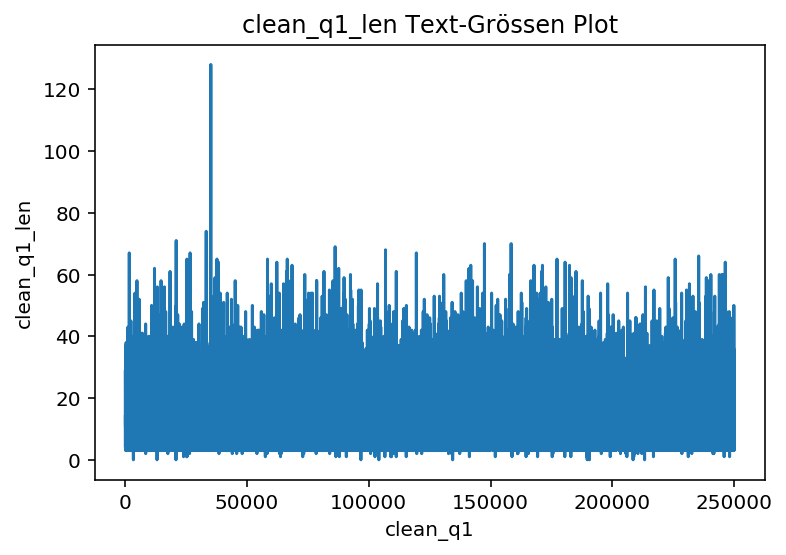

count    249998.000000
mean         11.118917
std           5.564081
min           0.000000
25%           7.000000
50%          10.000000
75%          13.000000
max         128.000000
dtype: float64


In [14]:
reviewTrainSizes("clean_q1")

Beschreibung der Review-Grössen



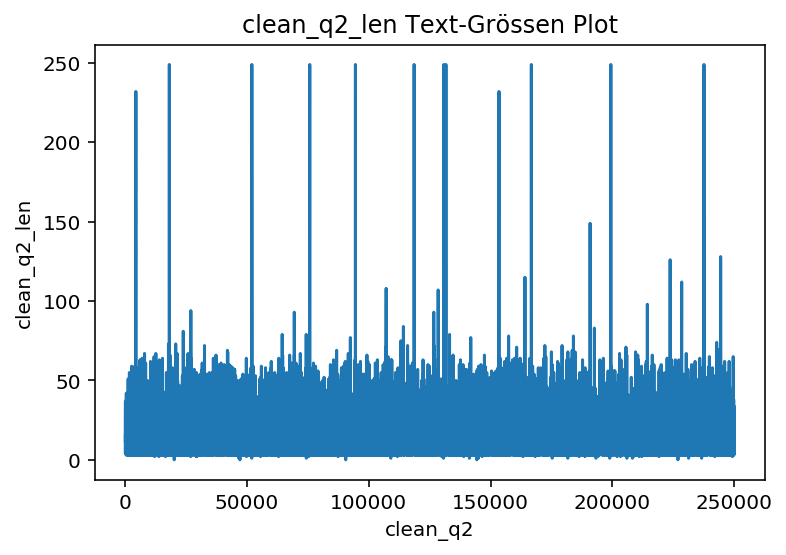

count    249998.000000
mean         11.370863
std           6.525784
min           0.000000
25%           7.000000
50%          10.000000
75%          13.000000
max         249.000000
dtype: float64


In [15]:
reviewTrainSizes("clean_q2")

In [16]:
MAX_LENGTH = 20

In [17]:
def create_sequence(data):
    encoded_set = tokenizer.texts_to_sequences(data)
    encoded_set_padded = pad_sequences(
        encoded_set, 
        maxlen=MAX_LENGTH, 
        padding="pre",
        truncating="pre") 
    
    sequences = [list(var) for var in encoded_set_padded]
    return np.array([np.array(token) for token in sequences])

In [18]:
train_q1 = create_sequence(df_train["clean_q1"])
train_q2 = create_sequence(df_train["clean_q2"])
eval_q1  = create_sequence(df_eval["clean_q1"])
eval_q2  = create_sequence(df_eval["clean_q2"])

In [19]:
def create_embedding_matrix(vocab_size, word2vec_path, token_word_index):

    glove_input = word2vec_path #"./glove.6B.300d.txt"
    word2vec_output = "./glove.6B.300d.txt.word2vec" 
    glove2word2vec(glove_input, word2vec_output)
    
    try:
        embeddings_index = gensim.models.KeyedVectors.load_word2vec_format( word2vec_output, binary=False)
    except:
        print("Error! 'glove.6B.300d.txt' konnte nicht geladen/gefunden werden!")
    
    embedding_matrix = np.zeros((vocab_size, 300))
    missed = []
    for word, i in token_word_index.items():
        try:
            embedding_vector = embeddings_index[word]
            embedding_matrix[i] = embedding_vector
        except KeyError:
            missed.append(word)
            
    return [embedding_matrix, missed, embeddings_index]

In [20]:
[embedding_matrix, missed, word_model] = create_embedding_matrix(VOCAB_SIZE, path_to_word2vec, tokenizer.word_index)

In [21]:
embedding_matrix.shape

(68831, 300)

In [22]:
word_model.most_similar("manhattan")

[('brooklyn', 0.707136869430542),
 ('midtown', 0.6984169483184814),
 ('york', 0.6746981143951416),
 ('bronx', 0.6093577146530151),
 ('queens', 0.5441600680351257),
 ('downtown', 0.5400195717811584),
 ('apartment', 0.5389279723167419),
 ('harlem', 0.5115177631378174),
 ('avenue', 0.504672646522522),
 ('neighborhood', 0.4913223087787628)]

In [23]:
EMBEDDING_DIM = embedding_matrix.shape[1]
print(f"Embedding-Dimensionen: {EMBEDDING_DIM}")

Embedding-Dimensionen: 300


In [24]:
print(f"Anzahl nicht gefundenen Wörter im Word2Vec: {len(missed)}")
missed[:10]

Anzahl nicht gefundenen Wörter im Word2Vec: 16944


['<OOV>',
 'kvpy',
 'ibps',
 'flipkart',
 'redmi',
 'sqrt',
 'demonetisation',
 'paytm',
 'manaphy',
 'brexit']

In [25]:
def cosine_distance(vectors):
    x, y = vectors
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

def roc_au(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

In [26]:
VOCAB_SIZE

68831

In [45]:
import tensorflow as tf

from keras import backend as K

from sklearn import metrics
from sklearn.metrics import roc_auc_score

from keras.models import Model
from keras.regularizers import l2

from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.layers import Input, Embedding, LSTM, Dense, Flatten, Concatenate, Multiply, Dropout, Subtract, Add
    
from keras.optimizers import Adam

embedding_layer = Embedding(VOCAB_SIZE, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_LENGTH, trainable=False) 
lstm_layer      = LSTM(64, activation="relu", dropout=0.1, recurrent_dropout=0.1, return_sequences=True)

# Question 1
q1_input = Input(shape=(MAX_LENGTH, ), dtype="int32")
q1       = embedding_layer(q1_input)
q1       = lstm_layer(q1)
q1       = Flatten()(q1)

# Question 2
q2_input = Input(shape=(MAX_LENGTH, ), dtype="int32")
q2       = embedding_layer(q2_input)
q2       = lstm_layer(q2)
q2       = Flatten()(q2)

x1 = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([q1, q2])

q1_multi = Multiply()([q1, q1])
q2_multi = Multiply()([q2, q2])
x2 = Subtract()([q1_multi, q2_multi])
    
x3 = Subtract()([q1, q2])
x3 = Multiply()([x3, x3])


conc = Concatenate(axis=-1)([x1,x2, x3])
x   = Dense(92, activation="relu")(conc)
x   = Dropout(0.2)(x)
out = Dense(1, activation="sigmoid")(x)

model = Model([q1_input, q2_input], out)

model.compile(optimizer=Adam(learning_rate=1e-3), loss="binary_crossentropy", metrics=['acc'] )

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 20, 300)      20649300    input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 20, 64)       93440       embedding_4[0][0]          

In [46]:
y_train = df_train["is_duplicate"].values.reshape(-1,1)
y_eval  = df_eval["is_duplicate"].values.reshape(-1,1)

In [47]:
from keras.callbacks import EarlyStopping

x_train = [train_q1,train_q2]
x_eval  = [eval_q1, eval_q2]

callback = EarlyStopping(monitor='val_loss', patience=4) 

trained_model = model.fit(
                x_train,
                y_train,
                epochs = 20,
                batch_size=64,
                validation_data=(x_eval,y_eval),
                callbacks=[callback]
                )

Train on 249998 samples, validate on 75000 samples
Epoch 1/20
249998/249998 [==============================] - 97s 390us/step - loss: 0.4941 - acc: 0.7562 - val_loss: 0.4686 - val_acc: 0.7756
Epoch 2/20
249998/249998 [==============================] - 97s 388us/step - loss: 0.4276 - acc: 0.7978 - val_loss: 0.4292 - val_acc: 0.7987
Epoch 3/20
249998/249998 [==============================] - 97s 387us/step - loss: 0.3992 - acc: 0.8133 - val_loss: 0.4296 - val_acc: 0.7982
Epoch 4/20
249998/249998 [==============================] - 97s 388us/step - loss: 0.3798 - acc: 0.8251 - val_loss: 0.4184 - val_acc: 0.8046
Epoch 5/20
249998/249998 [==============================] - 99s 396us/step - loss: 0.3655 - acc: 0.8322 - val_loss: 0.4141 - val_acc: 0.8090
Epoch 6/20
249998/249998 [==============================] - 98s 392us/step - loss: 0.3535 - acc: 0.8393 - val_loss: 0.4101 - val_acc: 0.8129
Epoch 7/20
249998/249998 [==============================] - 98s 390us/step - loss: 0.3417 - acc: 0.8461

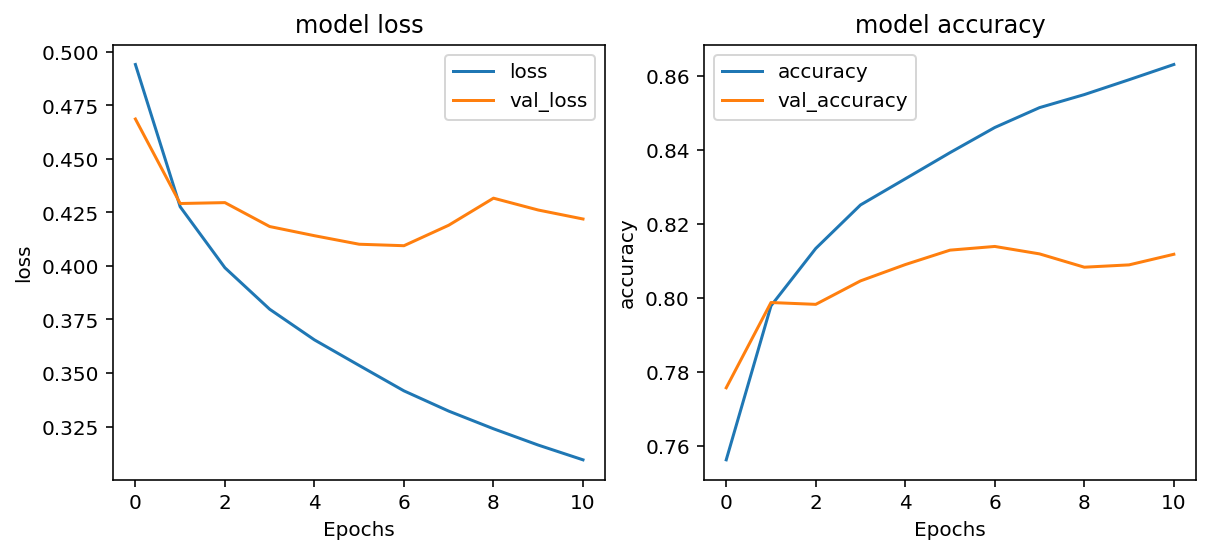

In [50]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1) 
plt.title("model loss")
plt.plot(trained_model.history["loss"])
plt.plot(trained_model.history["val_loss"])
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend(["loss", "val_loss"])

plt.subplot(1,3,2) 
plt.title("model accuracy")
plt.plot(trained_model.history["acc"])
plt.plot(trained_model.history["val_acc"])
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend(["accuracy", "val_accuracy"])

In [51]:
evalus = model.evaluate(x_eval, y_eval, verbose = 1)
print(evalus)

75000/75000 [==============================] - 12s 161us/step
[0.4219273351542155, 0.8117600083351135]


In [52]:
y_eval_predict = model.predict(x_eval, verbose=1)

75000/75000 [==============================] - 12s 156us/step


In [53]:
predict = y_eval_predict.reshape(1,-1)[0] > 0.5
y_true  = y_eval.reshape(1,-1)[0]

In [54]:
metric = metrics.classification_report(y_true, predict)
print(metric)

              precision    recall  f1-score   support

           0       0.90      0.79      0.84     47237
           1       0.70      0.85      0.77     27763

    accuracy                           0.81     75000
   macro avg       0.80      0.82      0.81     75000
weighted avg       0.83      0.81      0.81     75000



In [55]:
df_eval["predict"] = y_eval_predict

In [56]:
df_eval[df_eval["is_duplicate"] != predict]

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate,clean_q1,clean_q2,predict
2,250002,250002,492220,492221,How does a commodity market work?,How do commodity markets work?,0,"[how, does, a, commodity, market, work]","[how, do, commodity, markets, work]",0.867002
6,250006,250006,492228,492229,What courses should an instrumentation enginee...,What is the best job for an instrumentation en...,0,"[what, courses, should, an, instrumentation, e...","[what, is, the, best, job, for, an, instrument...",0.667705
14,250014,250014,492242,492243,I have trouble concentrating. I get distracted...,I get distracted very easily how can I improve...,1,"[i, have, trouble, concentrating, i, get, dist...","[i, get, distracted, very, easily, how, can, i...",0.489555
15,250015,250015,492244,492245,Where did Cain get his wife?,According to Genesis when God created Adam and...,1,"[where, did, cain, get, his, wife]","[according, to, genesis, when, god, created, a...",0.028506
18,250018,250018,492250,492251,What kind of music do you like and why?,What kind of music do you love?,1,"[what, kind, of, music, do, you, like, and, why]","[what, kind, of, music, do, you, love]",0.126966
...,...,...,...,...,...,...,...,...,...,...
74984,324984,324984,637466,637467,What is the clearest and most concise way to d...,What is the clearest and most concise way to d...,0,"[what, is, the, clearest, and, most, concise, ...","[what, is, the, clearest, and, most, concise, ...",0.820355
74987,324987,324987,637472,637473,Should I breakup with my girlfriend if we have...,Should I breakup with my girlfriend only becau...,0,"[should, i, breakup, with, my, girlfriend, if,...","[should, i, breakup, with, my, girlfriend, onl...",0.932317
74988,324988,324988,637474,637475,Is NASA's moon landing a hoax?,Is the moon landing fake because the astronaut...,1,"[is, nasa, is, moon, landing, a, hoax]","[is, the, moon, landing, fake, because, the, a...",0.357773
74997,324997,324997,637491,637492,What do hedgehogs look like?,What do hedgehogs like?,0,"[what, do, hedgehogs, look, like]","[what, do, hedgehogs, like]",0.769938


In [59]:
fpr, tpr, thresholds = metrics.roc_curve(y_true, predict)


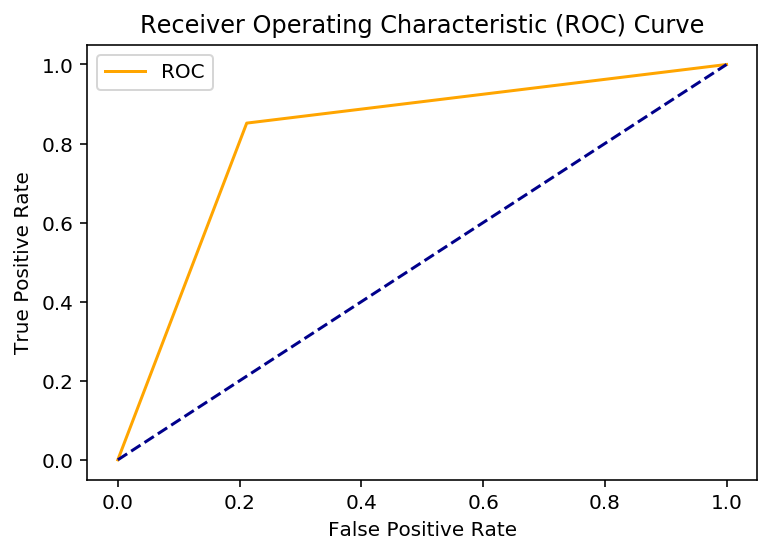

In [60]:
plt.plot(fpr, tpr, color="orange", label="ROC")
plt.plot([0, 1], [0, 1], color="darkblue", linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()